This notebook performs all the modeling steps on the combined Airline On-Time Performance, Origin & Destination Survey, and NOAA GHCND data. I first set up the data for modeling and then evaluate four models:

* `LRFlight`, a logistic regression model with only flight schedule features
* `LRFlightWX`, a logistic regression model with flight schedule and weather features
* `RFFlight`, a random forest model with only flight schedule features
* `RFFlightWX`, a random forest model with flight schedule and weather features

I use these models because for this stage of the project, I am emphasizing interpretability and want to be able to have some sense of which features are contributing to incidence of flight delays.

The analysis in this notebook is preliminary in nature as the random forest models, in particular, are not tuned exhaustively in evaluating each model.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import math
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

plt.style.use('fivethirtyeight')

Get all the flight schedule/weather data, then the business passenger ratios for given origin-destination pairs (flight routes), then the hourly scheduled volume data for each airport for each year. 

In [2]:
with open('aotp_all_data.pkl', 'rb') as picks:
    aotp_nyc_data = pickle.load(picks)

In [3]:
aotp_nyc_data = aotp_nyc_data.reset_index()

In [4]:
with open('bus_pass_ratio.pkl', 'rb') as picks2:
    bus_pass_ratio = pickle.load(picks2)

In [5]:
bus_pass_ratio1617 = bus_pass_ratio[bus_pass_ratio['Year'] < 2018]
bus_pass_ratio18 = bus_pass_ratio[bus_pass_ratio['Year'] == 2018]

In [6]:
with open('volhr_16.pkl', 'rb') as picks3:
    volhr_16 = pickle.load(picks3)

with open('volhr_17.pkl', 'rb') as picks4:
    volhr_17 = pickle.load(picks4)
    
with open('volhr_18.pkl', 'rb') as picks5:
    volhr_18 = pickle.load(picks5)

Merge all the combined flight schedule/weather data with the business passenger ratios for a given year, quarter, O/D pair.

In [7]:
aotp_nyc_data = aotp_nyc_data.merge(bus_pass_ratio, on=['Year', 'Quarter', 'Origin', 'Dest'])

In [8]:
aotp_nyc_data['ArrDel15'] = aotp_nyc_data['ArrDel15'].astype('float')

Convert some of the weather data measurements. Original units given [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) in Section III.

In [9]:
aotp_nyc_data['ATemp'] = (9/5)*(aotp_nyc_data['ATemp'] / 10) + 32
aotp_nyc_data['ATempDest'] = (9/5)*(aotp_nyc_data['ATempDest'] / 10) + 32

In [10]:
aotp_nyc_data['Precip'] = (aotp_nyc_data['Precip'] / 10) / 25.4
aotp_nyc_data['PrecipDest'] = (aotp_nyc_data['PrecipDest'] / 10) / 25.4

In [11]:
aotp_nyc_data['AWind'] = (aotp_nyc_data['AWind'] / 10) * 2.23694
aotp_nyc_data['AWindDest'] = (aotp_nyc_data['AWindDest'] / 10) * 2.23694

Here we get, for each airport and each hour, the percentage at capacity for scheduled hourly volume. We create a column `AirportPerf` in the main dataframe for this metric.

In [12]:
volhr = pd.concat([volhr_16, volhr_17], axis=0)
volhr = pd.concat([volhr, volhr_18], axis=0)

In [13]:
volhr['AirportPerf'] = volhr['VolHr'] / volhr['MaxVolHr']

In [14]:
volhr = volhr[['FlightDate', 'TimeBlk', 'Airport', 'AirportPerf']]

For each hour and airport, put the percentage at capacity (for scheduled volume) `AirportPerf` into a dicitonary. Then use two specifically constructed functions (for the given data we are evaluating) to be applied on the main dataframe using the dictionary we've put together to get the `AirportPerf` value for the origin and destination for each flight, to be stored respectively as `OrigPerf` and `DestPerf` in the dataframe. 

In [15]:
volhrdict = volhr.set_index(['FlightDate', 'TimeBlk', 'Airport']).to_dict()

In [16]:
def get_orig_perf(row):
    tup = (row['FlightDate'], row['DepTimeBlk'], row['Origin'])
    return volhrdict['AirportPerf'][tup]    

In [17]:
aotp_nyc_data['OrigPerf'] = aotp_nyc_data.apply(get_orig_perf, axis=1)

In [18]:
def get_dest_perf(row):
    tup = (row['FlightDate'], row['ArrTimeBlk'], row['Dest'])
    return volhrdict['AirportPerf'][tup]

In [19]:
aotp_nyc_data['DestPerf'] = aotp_nyc_data.apply(get_dest_perf, axis=1)

In [20]:
aotp_nyc_data.head()

,level_0,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,...,Unnamed: 109,ATemp,Precip,AWind,ATempDest,PrecipDest,AWindDest,BusPassRatio,OrigPerf,DestPerf
0,0,88,2016,1,1,1,5,2016-01-01,AA,19805,...,NaN,42.44,0,14.5401,35.78,0,4.92127,0.006813,0.562500,0.808824
1,1,89,2016,1,1,2,6,2016-01-02,AA,19805,...,NaN,37.58,0,12.9743,33.44,0,5.59235,0.006813,0.479167,0.882353
2,2,90,2016,1,1,3,7,2016-01-03,AA,19805,...,NaN,40.28,0,14.0927,37.04,0.019685,9.17145,0.006813,0.500000,0.911765
3,3,91,2016,1,1,4,1,2016-01-04,AA,19805,...,NaN,33.8,0,19.9088,35.96,0.149606,7.6056,0.006813,0.520833,0.882353
4,4,92,2016,1,1,5,2,2016-01-05,AA,19805,...,NaN,19.04,0,12.3032,38.12,0.110236,5.36866,0.006813,0.520833,0.705882


Use the 2016-17 data for training/validation and the 2018 Q1 data as the testing/holdout.

In [21]:
aotp_nyc_data1617 = aotp_nyc_data[aotp_nyc_data['Year'] < 2018]
aotp_nyc_data18 = aotp_nyc_data[aotp_nyc_data['Year'] == 2018]

In [22]:
del(aotp_nyc_data)

Define functions below to:

* Set up data for modeling
* Split the training set (2016-17 data) into further train/validation sets
* Evaluate the given candidate model (as specified above) and collect training and testing scores

In [23]:
def org_data(df, idx_cols, num_cols, cat_cols, response):
    '''
    This function organizes a dataframe into a smaller dataframe that includes only the response
    variable and features to be evaluated in modeling.
    
    Given:
    df, dataframe 
    idx_cols, index variable columns in df (not to be considered in any model)
    num_cols, numerical variable columns in df
    cat_cols, categorical variable columns in df
    response, response variable column in df
    
    Return:
    all_data, a dataframe including only the response and features incorporated in a given model
    '''
    
    all_cols = response + idx_cols + num_cols + cat_cols
    all_data = df[all_cols]
    all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)
    return all_data

In [24]:
def way_specific_train_test_split(dmat, split, response, to_drop):
    '''
    This function performs a train/validation split on the main "training" set -- this is specific
    to this particular project. The split is conducted on quarters of Year 2017:
    -Train: all of 2016, Validation: all of 2017
    -Train: 2016 + Q1 2017, Valdiation: Q2-4 2017
    -Train: 2016 + Q1-2 2017, Validation: Q3-4 2017
    -Train: 2016 + Q1-3 2017, Validation: Q4 2017
    
    Given:
    df, dataframe
    split, defining the quarter of 2017 to split on
    response, the response variable column in df
    to_drop, columns to drop from df
    
    Return:
    Xtrain, ytrain, Xtest, ytest, the data matrix and response vector for the train and validation sets
    '''
    train_set = dmat[(dmat['Year'] == 2016) | ((dmat['Year'] == 2017) & (dmat['Quarter'] < split))]
    ytrain = train_set[response]
    Xtrain = train_set.drop(to_drop, axis=1)

    test_set = dmat[(dmat['Year'] == 2017) & (dmat['Quarter'] >= split)]
    ytest = test_set[response]
    Xtest = test_set.drop(to_drop, axis=1)
    
    return Xtrain, ytrain, Xtest, ytest

In [25]:
def fit_eval(model, df, idx_cols, num_cols, cat_cols, response):
    '''
    This function sets up data for modeling, splits into train and validation sets iteratively,
    and fits/scores a model (logistic regression or random forest) across those splits. The 
    scoring metric is a modification of F1 score replacing precision with accuracy.
    
    Given:
    model, the model to be evaluated
    df, dataframe 
    idx_cols, index variable columns in df (not to be considered in any model)
    num_cols, numerical variable columns in df
    cat_cols, categorical variable columns in df
    response, response variable column in df
    
    Return:
    best_coefs, the coefficients (or feature importance ratings) of the model in its best split
    train_scores, the training scores for each split
    test_scores, the validation scores for each split
    '''
    datadf = org_data(df, idx_cols, num_cols, cat_cols, response)
    #print(datadf.columns.values)
    rec_train = []
    rec_test = []
    acc_train = []
    acc_test = []
    train_scores = []
    test_scores = []
    coefs = []
    for q in range(1,5):
        
        Xtrain, ytrain, Xtest, ytest = way_specific_train_test_split(datadf, q, response, response+idx_cols)
        
        sc = preprocessing.StandardScaler()
        Xtrain[num_cols] = sc.fit_transform(Xtrain[num_cols])        
        
        clf = model.fit(Xtrain, np.ravel(ytrain))      
        ypred = clf.predict(Xtrain)
        
        acc_train  = clf.score(Xtrain, ytrain)
        rec_train = metrics.recall_score(ytrain, ypred)        
        score_tr = 2 * ((acc_train * rec_train)/(acc_train + rec_train))
        train_scores.append(score_tr)
        
        Xtest[num_cols] = sc.transform(Xtest[num_cols])
        ypred2 = clf.predict(Xtest)
        
        rec_test = metrics.recall_score(ytest, ypred2)
        acc_test = clf.score(Xtest,ytest)
        score_test = 2 * ((acc_test * rec_test)/(acc_test + rec_test))
        test_scores.append(score_test)
        
        if model == lr:
            coefs.append(model.coef_)
        elif model == rf:
            coefs.append(np.ravel(model.feature_importances_))
        else:
            pass
            
        features = Xtest.columns.values
        zipped = zip(features, np.ravel(coefs[np.argmax(test_scores)]))
        best_coefs = sorted(list(zipped), key=lambda tup: abs(tup[1]), reverse=True)
    
#     p,r,t = metrics.precision_recall_curve(best_ytest, best_ysc)

#     t=np.vstack([t.reshape([-1,1]),1])

#     plt.plot(t,p)
#     plt.plot(t,r);
#     plt.title('Precision Recall Curve')
#     plt.legend(['Precision', 'Recall'])
#     plt.xlabel('Threshold')
    
    return best_coefs, train_scores, test_scores

Define the parts of the main dataframe with all flight schedule and weather data to be used in the model as inputs for the above functions.

In [26]:
response = ['ArrDel15']
idx_cols = ['Year', 'Quarter']
num_cols = ['AirTime', 'BusPassRatio', 'OrigPerf', 'DestPerf']
num_cols_wx = ['AirTime', 'ATemp', 'Precip', 'AWind', 'ATempDest', 'PrecipDest', 'AWindDest', 'BusPassRatio', 'OrigPerf', 'DestPerf']
cat_cols = ['Month', 'DayOfWeek', 'Origin', 'UniqueCarrier', 'DepTimeBlk', 'ArrTimeBlk']

Run logistic regression for the case with no weather features and the case with weather features. Specify `balanced` for `class_weight` argument because of imbalanced classes.

In [28]:
lr = LogisticRegression(class_weight='balanced')
lrcoefs_no_wx, lrtrain_no_wx, lrtest_no_wx = fit_eval(lr, aotp_nyc_data1617, idx_cols, num_cols, cat_cols, response)
lrcoefs_wx, lrtrain_wx, lrtest_wx = fit_eval(lr, aotp_nyc_data1617, idx_cols, num_cols_wx, cat_cols, response)

Do the same for a random forest classifier. Some manual tuning (a more exhaustive grid search is included in another notebook as further exploration) led to using the specified parameters (max_depth for all generated trees, max_features for number of features to include in each generated tree, n_estimators for the number of trees to generate and sample) to fit for both the no-weather/weather cases.

In [30]:
rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=5, n_estimators=300, class_weight='balanced')
rfcoefs_no_wx, rftrain_no_wx, rftest_no_wx = fit_eval(rf, aotp_nyc_data1617, idx_cols, num_cols, cat_cols, response)
rfcoefs_wx, rftrain_wx, rftest_wx = fit_eval(rf, aotp_nyc_data1617, idx_cols, num_cols_wx, cat_cols, response)

In [32]:
print(lrtest_no_wx)
print(lrtest_wx)
print(rftest_no_wx)
print(rftest_wx)

[0.6145666329044107, 0.6200484955410364, 0.630586159544362, 0.588021908678698]
[0.643395299707981, 0.6472902171100534, 0.6513328917869591, 0.6074669247881543]
[0.6300333071893711, 0.6335832396689689, 0.6276820078012679, 0.6097936628341014]
[0.6433099537935427, 0.6441245934389527, 0.6480400374311654, 0.6339752020878067]


Collect the scores above for each model across all splits into a dataframe to visualize results and do a preliminary model selection.

In [45]:
scores_df = pd.DataFrame(np.array([lrtest_no_wx, rftest_no_wx, lrtest_wx, rftest_wx])).T
scores_df.columns = ['LRFlight', 'RFFlight', 'LRFlightWX', 'RFFlightWX']

In [46]:
scores_df

,LRFlight,RFFlight,LRFlightWX,RFFlightWX
0,0.614567,0.630033,0.643395,0.643310
1,0.620048,0.633583,0.647290,0.644125
2,0.630586,0.627682,0.651333,0.648040
3,0.588022,0.609794,0.607467,0.633975


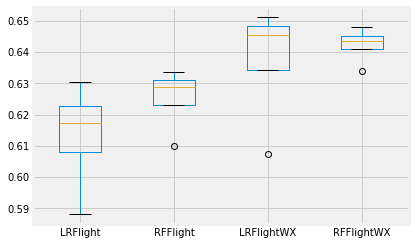

In [47]:
scores_df.boxplot()

The random forest model including both flight schedule and weather features performs better in terms of average value and the lower variance across the splits. Now let's fit this model back on the entire training set, see how it performs on the holdout set (2018 Q1 data), and get the feature importances.

In [178]:
rf2 = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=5, n_estimators=300, class_weight='balanced')

In [179]:
data_mod = org_data(aotp_nyc_data1617, idx_cols, num_cols_wx, cat_cols, response)

In [180]:
drop_cols = idx_cols + response

In [181]:
sc = preprocessing.StandardScaler()
X = data_mod.drop(drop_cols, axis=1)
Y = data_mod[response]

In [182]:
X[num_cols] = sc.fit_transform(X[num_cols])    
clf = rf2.fit(X, np.ravel(Y))      
ypred = clf.predict(X)

In [183]:
data_mod_holdout = org_data(aotp_nyc_data18, idx_cols, num_cols_wx, cat_cols, response)

In [184]:
Xholdout = data_mod_holdout.drop(drop_cols, axis=1)
Yholdout = data_mod_holdout[response]

In [185]:
# Hack that is needed b/c the holdout set does not have columns for months 4-12
for z in range(4,13):
    col_str = 'Month_' + str(z)
    Xholdout[col_str] = pd.Series(np.zeros(len(Xholdout)))

In [186]:
Xholdout.fillna(0, inplace=True)

In [187]:
Xholdout[num_cols] = sc.transform(Xholdout[num_cols])
ypred2 = clf.predict(Xholdout)

In [188]:
rec_test = metrics.recall_score(Yholdout, ypred2)
acc_test = clf.score(Xholdout,Yholdout)
score_test = 2 * ((acc_test * rec_test)/(acc_test + rec_test))
score_test

0.5676220217834075

In [189]:
rec_test, acc_test

(0.5272988505747126, 0.6146229726234899)

Performance appears to be fairly poor on the holdout set, at least relative to what was observed in the train/validation step. From the recall above, this model only correctly identifies delayed flights as delayed slightly more than half the time. Let's now construct and look at the confusion matrix from applying this classifier to the 2016-17 flight data.

In [198]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [199]:
cm=confusion_matrix(Yholdout, ypred2, labels=None)

In [202]:
import itertools
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Blues):
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(range(0,2), ['Not Delayed', 'Delayed'])
    plt.yticks(range(0,2), ['Not Delayed', 'Delayed'])
    plt.title('RFFlightWX Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

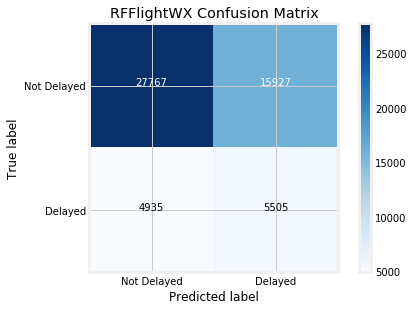

In [203]:
plot_confusion_matrix(cm)

The model appears to perform better in correctly identifying flights that are not delayed, compared to the same task for delayed flights. An enormous number of false positives are produced, and as previously stated, nearly half of actual delayed flights are misclassified.

In [194]:
feat_imp = np.ravel(rf.feature_importances_)
features = Xholdout.columns.values
zipped = zip(features, feat_imp)
feat_imp_sort = sorted(list(zipped), key=lambda tup: abs(tup[1]), reverse=True)[:10]

In [195]:
feat_imp_sort[:10]

[('Precip', 0.23692137074883385),
 ('OrigPerf', 0.13103670145820392),
 ('ATemp', 0.09613132668626703),
 ('PrecipDest', 0.07719323517510668),
 ('AirTime', 0.07468767893279721),
 ('DepTimeBlk_1600-1659', 0.06705357892696384),
 ('AWind', 0.06063432018479393),
 ('DepTimeBlk_1700-1759', 0.04142970352104272),
 ('ArrTimeBlk_1600-1659', 0.03275296589078022),
 ('ArrTimeBlk_1900-1959', 0.018956457910477103)]

([<matplotlib.axis.YTick at 0x1a5ee328d0>,
 <a list of 10 Text yticklabel objects>)

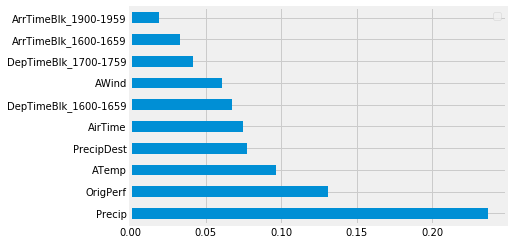

In [197]:
feat_imp_df = pd.DataFrame.from_records(feat_imp_sort)
feat_imp_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(feat_imp_df)), feat_imp_df[0])

Of the 10 most important features identified, 3 of the top 4 and 4 of the top 7 are weather features, particularly those at the origin airport. Only total daily precipitation appears to have an impact at destination airports. Weather at the origin airport and precipitation at the destination contribute substantially to differentiating between flights that are delayed and not delayed.

Flight schedule features that are important (in this same sense) include late afternoon/evening scheduled departure times and scheduled arrival times. This seems sensible given that these time periods will generally have lots of volume being associated with travel for business. Notably `OrigPerf`, the percentage of capacity of scheduled hourly volume at origin airports.

This latter point and all origin weather features coming up as most important features indicate that scheduled volume at the three NYC airports and anything that may impact operation of that volume (like inclement weather in the region) may have downstream impacts such as large arrival delays.    

Now save the training and holdout dataframes for future use in hyperparameter tuning.

In [ ]:
with open('aotp_nyc_data_all1617.pkl', 'wb') as pickle_main1:
    pickle.dump(aotp_nyc_data1617, pickle_main1)

In [ ]:
with open('aotp_nyc_data_all18.pkl', 'wb') as pickle_main2:
    pickle.dump(aotp_nyc_data18, pickle_main2)

In [77]:
estimators = np.arange(100, 1010, 100)
depth = np.arange(3, 10, 1)
feature_pct = np.arange(.1, .55, .05)

In [ ]:
best_test = 0
for x in estimators:
    for y in feature_pct:
        for z in depth:
            rf = RandomForestClassifier(n_jobs=-1, max_features=y, max_depth=z, n_estimators=x, random_state=1, class_weight='balanced')
            rfcoefs_no_wx, rftrain_no_wx, rftest_no_wx = fit_eval(rf, aotp_nyc_data1617, idx_cols, num_cols, cat_cols, response)
            mean_test_no_wx = np.mean(rftest_no_wx)
            if mean_test_no_wx > best_test:
                best_test = mean_test_no_wx
                best_est = x
                best_feat = y
                best_depth = z

In [ ]:
print(best_est)
print(best_feat)
print(best_depth)